# Monitoring coastal erosion in Port Beach (Western Australia)

## Step by Step
1. Import necessary packages.
2. Connect to the Digital Earth Australia (DEA) datacube.
3. Define the extent of the study area.
4. Load all available Landsat 5, 7, 8, and 9 Analysis Ready Data (ARD) products as a stack.
5. Compute the Modified Normalized Difference Water Index (MNDWI).
6. Calculate tide heights using the Finite Element Solution 2014 (FES2014) tide model.
7. Filter Landsat images based on tide height.
8. Combine tidally-masked data to create annual median composites.
9. Extract coastlines vectors using subpixel waterline extraction.
10. Calculate rates of coastal change at 30 m intervals along Australia's non-rocky coastlines using linear regression.
11. Perform possible validation with Vegetation Lines (DOT-023).
***

### 1. Import necessary packages.

In [2]:
pip install -q git+https://github.com/GeoscienceAustralia/dea-coastlines.git --disable-pip-version-check

Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline

import datacube
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard, mostcommon_crs
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.spatial import subpixel_contours
from dea_tools.coastal import tidal_tag
from coastlines.vector import points_on_line, annual_movements, calculate_regressions
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mprodriguezn15@gmail.com/proxy/8787/status,
Dashboard: /user/mprodriguezn15@gmail.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43537,Workers: 1
Dashboard: /user/mprodriguezn15@gmail.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:45771,Total threads: 2
Dashboard: /user/mprodriguezn15@gmail.com/proxy/45607/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:36275,


### 2. Connect to the Digital Earth Australia (DEA) datacube.

In [4]:
dc = datacube.Datacube(app='Coastal_erosion_FINAL')

### 3. Define the extent of the study area.

In [5]:
lat_range = (-32.0548, -32.029)
lon_range = (115.715, 115.749)
display_map(x=lon_range, y=lat_range)

### 4. Load all available Landsat 5, 7, 8, and 9 Analysis Ready Data (ARD) products as a stack.

In [6]:
# Create the 'query' dictionary object, which contains the longitudes, 
time_range = ('1988', '2022')

query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_swir_1'],
    'resolution': (-30, 30),
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='ga_ls8c_ard_3', query=query)

# Load available data from all three Landsat satellites
landsat_ds = load_ard(dc=dc, 
                      products=['ga_ls5t_ard_3', 
                                'ga_ls7e_ard_3', 
                                'ga_ls8c_ard_3',
                                'ga_ls9c_ard_3'],                      
                      output_crs=output_crs,
                      align=(15, 15),
                      group_by='solar_day',
                      dask_chunks={},
                      **query)

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Applying fmask pixel quality/cloud mask
Returning 2014 time steps as a dask array


In [7]:
landsat_ds

<xarray.Dataset>
Dimensions:       (time: 2014, y: 98, x: 109)
Coordinates:
  * time          (time) datetime64[ns] 1988-01-03T01:34:18.579015 ... 2022-1...
  * y             (y) float64 -3.544e+06 -3.544e+06 ... -3.547e+06 -3.547e+06
  * x             (x) float64 3.787e+05 3.787e+05 ... 3.819e+05 3.819e+05
    spatial_ref   int32 32650
Data variables:
    nbart_red     (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_green   (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
Attributes:
    crs:           epsg:32650
    grid_mapping:  spatial_ref

Exporting image to ../figures/RGB_Timesteps


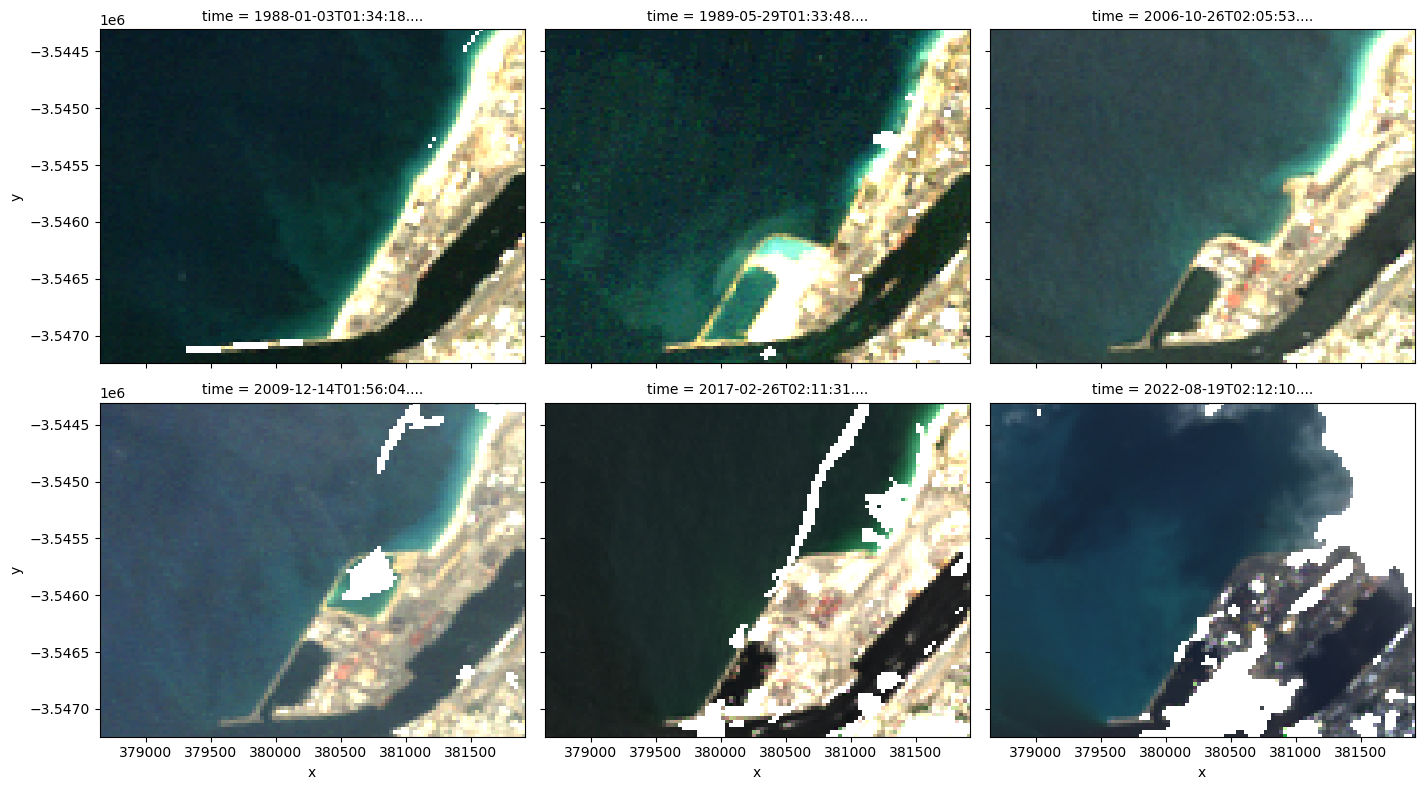

In [8]:
# Generate RGB plots at selected timesteps
timestep=[0,50,805,1006, 1510,1980]
rgb(landsat_ds, 
    index= timestep,
    percentile_stretch=(0.00, 0.95),
    col_wrap=3,
    size=4,
    savefig_path='../figures/RGB_Timesteps')

### 5.  Compute the Modified Normalized Difference Water Index (MNDWI).

In [9]:
# Calculate the water index
landsat_ds = calculate_indices(landsat_ds, index='MNDWI', 
                               collection='ga_ls_3')
landsat_ds

<xarray.Dataset>
Dimensions:       (time: 2014, y: 98, x: 109)
Coordinates:
  * time          (time) datetime64[ns] 1988-01-03T01:34:18.579015 ... 2022-1...
  * y             (y) float64 -3.544e+06 -3.544e+06 ... -3.547e+06 -3.547e+06
  * x             (x) float64 3.787e+05 3.787e+05 ... 3.819e+05 3.819e+05
    spatial_ref   int32 32650
Data variables:
    nbart_red     (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_green   (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    MNDWI         (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
Attributes:
    crs:           epsg:32650
    grid_mapping:  spatial_ref

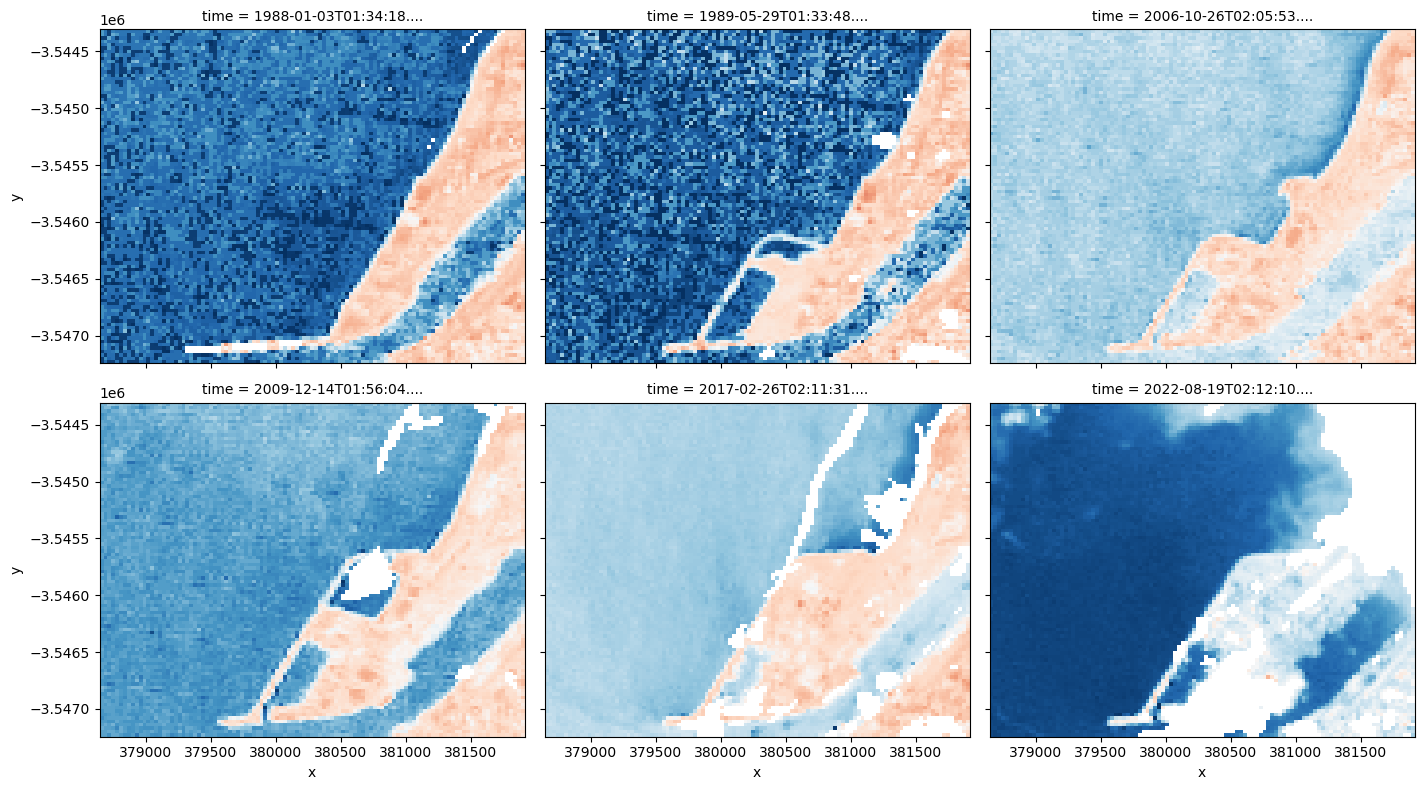

In [10]:
landsat_ds.MNDWI.isel(time=timestep).plot(col='time',
                                           cmap='RdBu',
                                           col_wrap=3,
                                           size=4,
                                           aspect=landsat_ds.odc.geobox.aspect,
                                           vmin=-1,
                                           vmax=1,
                                           add_colorbar=False)
                                         
plt.savefig('../figures/MNDWI_Timesteps')

### 6. Calculate tide heights using the Finite Element Solution 2014 (FES2014) tide model.

In [11]:
# Calculate tides for each timestep in the satellite dataset
landsat_ds = tidal_tag(ds=landsat_ds, tidepost_lat=None, tidepost_lon=None)

# Print the output dataset with new `tide_height` variable
landsat_ds

Setting tide modelling location from dataset centroid: 115.73, -32.04
Modelling tides using FES2014 tidal model


<xarray.Dataset>
Dimensions:       (time: 2014, y: 98, x: 109)
Coordinates:
  * time          (time) datetime64[ns] 1988-01-03T01:34:18.579015 ... 2022-1...
  * y             (y) float64 -3.544e+06 -3.544e+06 ... -3.547e+06 -3.547e+06
  * x             (x) float64 3.787e+05 3.787e+05 ... 3.819e+05 3.819e+05
    spatial_ref   int32 32650
Data variables:
    nbart_red     (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_green   (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    MNDWI         (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    tide_m        (time) float64 -0.2201 -0.2747 0.004453 ... -0.3386 -0.3558
Attributes:
    crs:           epsg:32650
    grid_mapping:  spatial_ref

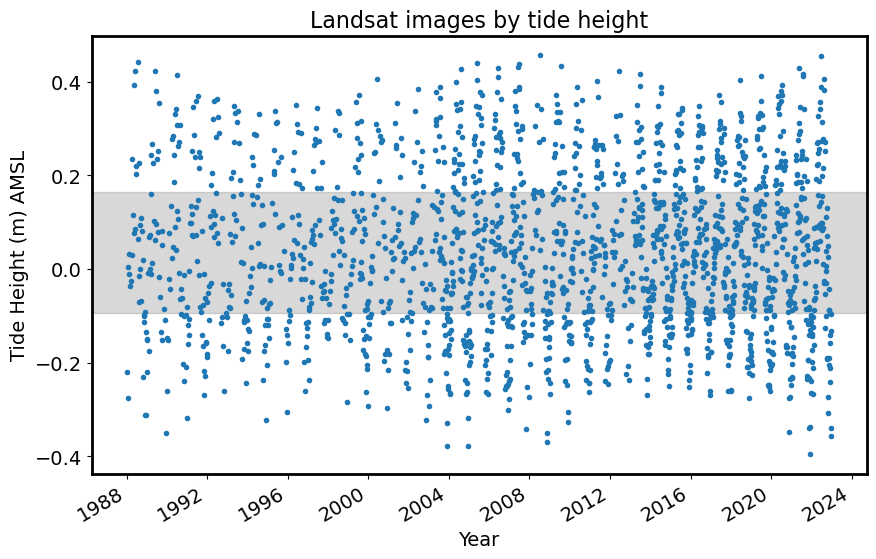

In [12]:
tide_range = (0.25, 0.75)
# Calculate the min and max tide heights to include based on the % range
min_tide, max_tide = landsat_ds.tide_m.quantile(tide_range) 

# Plot the resulting tide heights for each Landsat image:
fig = plt.figure(figsize=(10, 6))
landsat_ds.tide_m.plot(marker="o", markersize=3, linestyle="None")
plt.axhspan(min_tide, max_tide, color='grey', alpha=0.3)
plt.title('Landsat images by tide height',fontsize=16) 
plt.xlabel('Year',fontsize=14)
plt.ylabel('Tide Height (m) AMSL',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplots_adjust(bottom=0.15)
plt.savefig('../figures/Tide_Height_Vs_Time')

### 7. Filter Landsat images based on tide height.

In [13]:
# Keep timesteps larger than the min tide, and smaller than the max tide
landsat_filtered = landsat_ds.sel(time=(landsat_ds.tide_m > min_tide) &
                                       (landsat_ds.tide_m <= max_tide))
landsat_filtered

<xarray.Dataset>
Dimensions:       (time: 1006, y: 98, x: 109)
Coordinates:
  * time          (time) datetime64[ns] 1988-01-26T01:40:54.852557 ... 2022-1...
  * y             (y) float64 -3.544e+06 -3.544e+06 ... -3.547e+06 -3.547e+06
  * x             (x) float64 3.787e+05 3.787e+05 ... 3.819e+05 3.819e+05
    spatial_ref   int32 32650
Data variables:
    nbart_red     (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_green   (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    MNDWI         (time, y, x) float32 dask.array<chunksize=(1, 98, 109), meta=np.ndarray>
    tide_m        (time) float64 0.004453 0.03228 -0.0107 ... -0.08857 -0.08699
Attributes:
    crs:           epsg:32650
    grid_mapping:  spatial_ref

### 8. Combine tidally-masked data to create annual median composites.

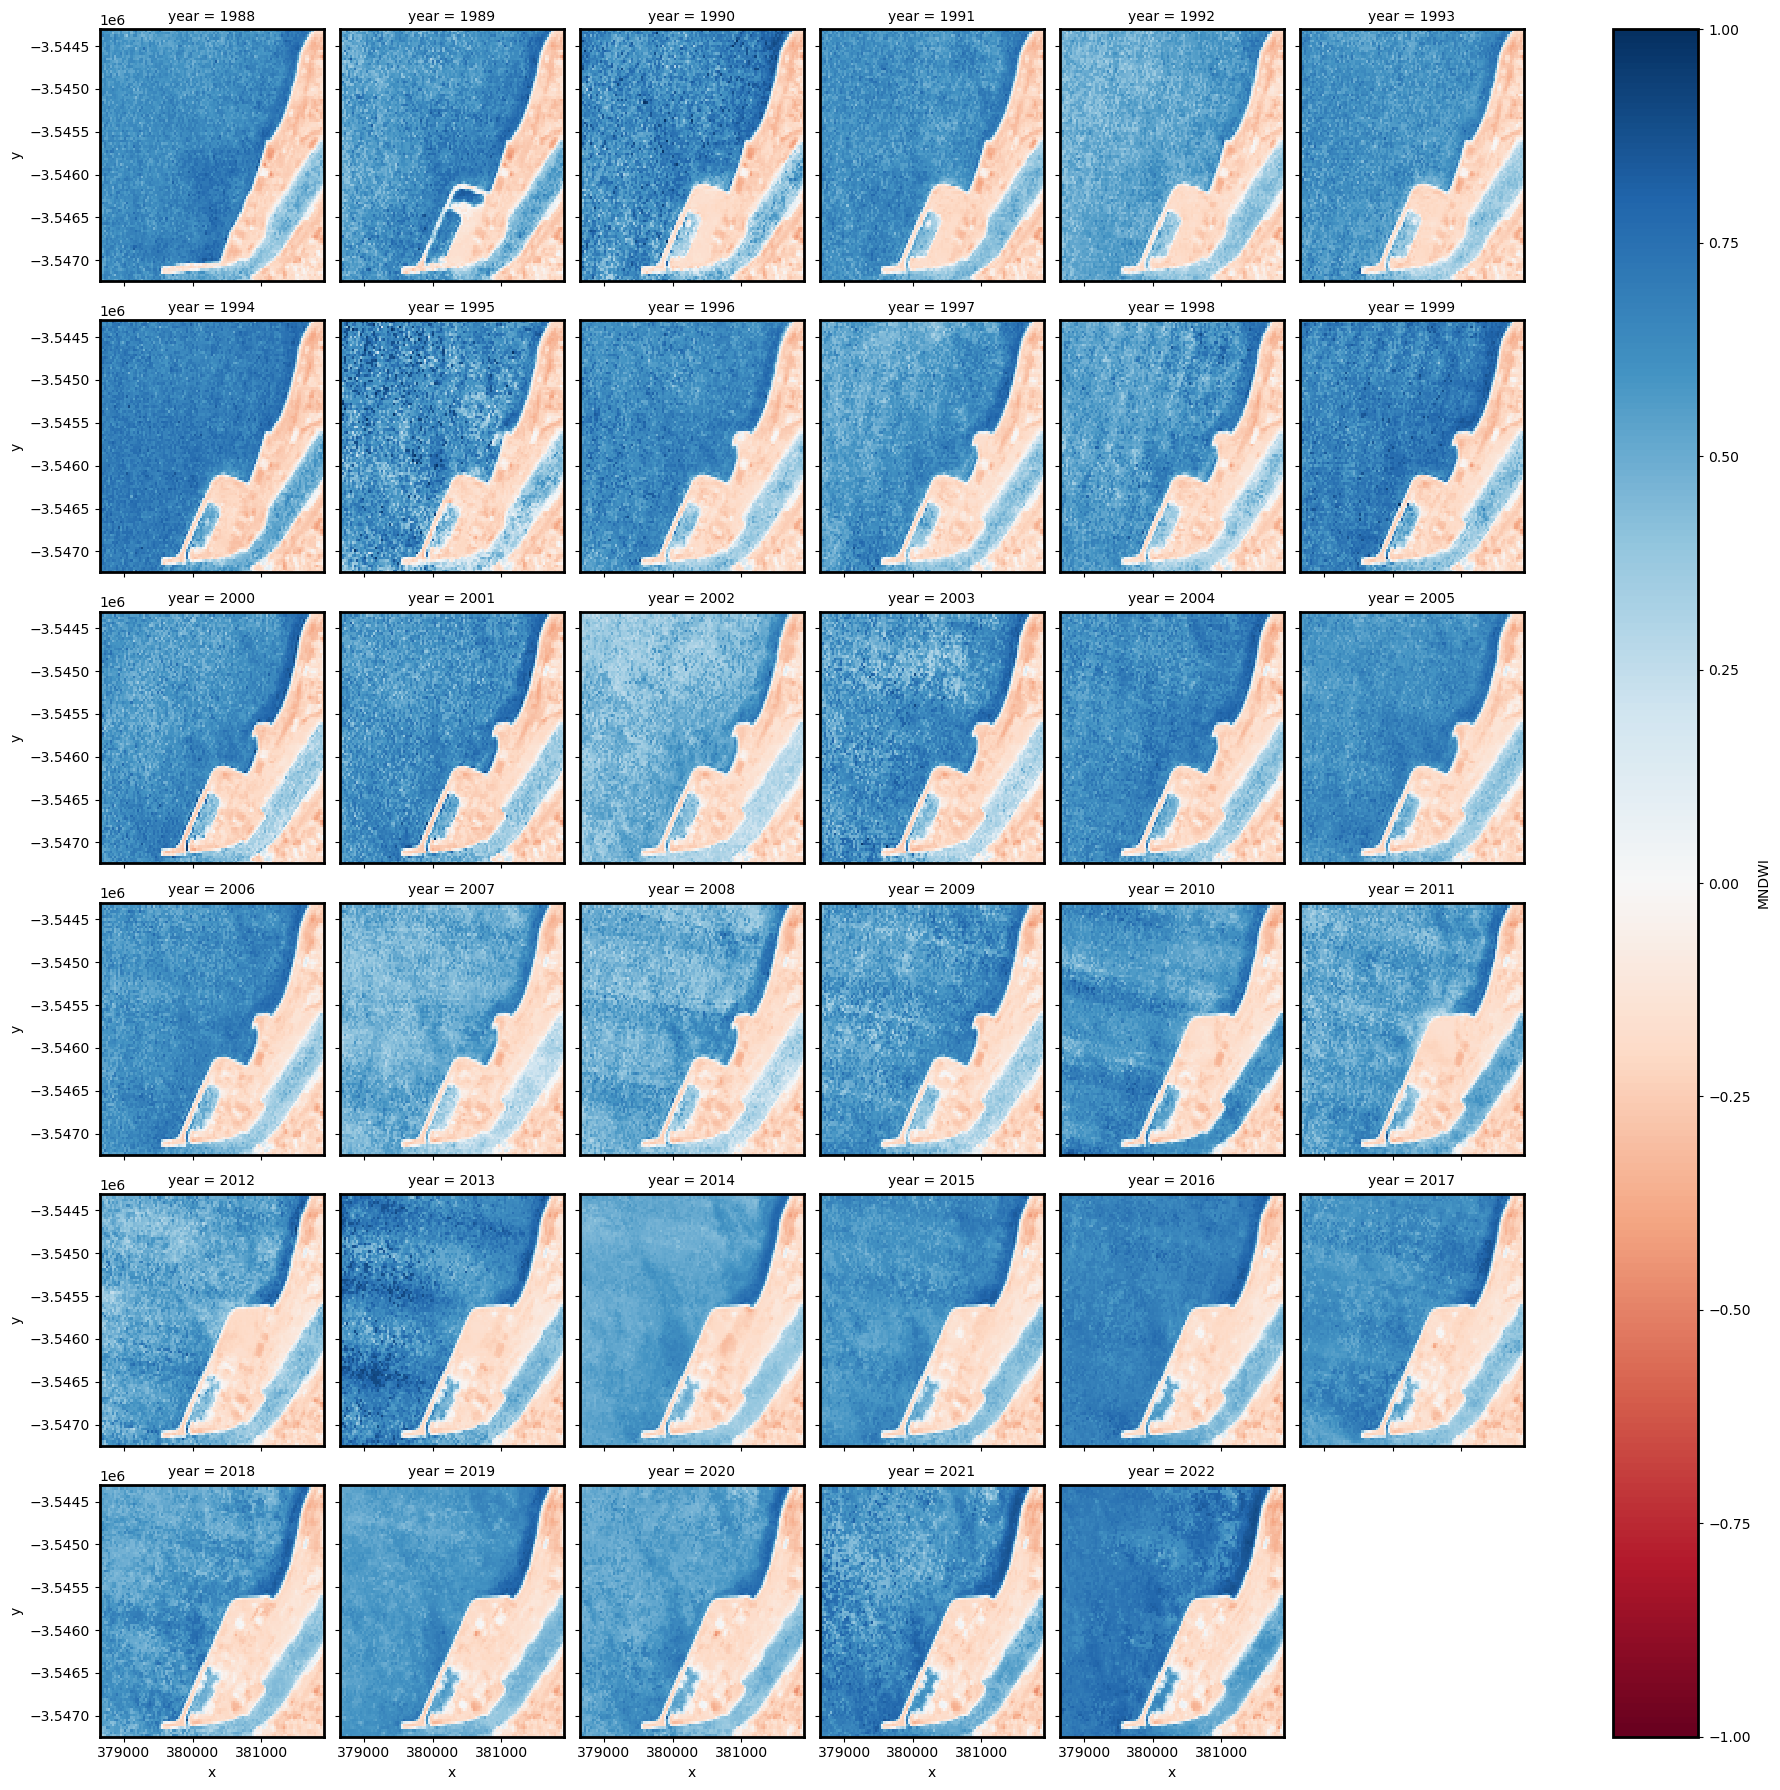

In [14]:
time_step= '1Y'
# Combine into summary images by `time_step`
landsat_summaries = (landsat_filtered[['MNDWI']]
                     .resample(time=time_step)
                     .median('time')
                     .compute()
                    )

# Shut down Dask client now that we have processed the data we need
client.close()

# Rename each image by year
landsat_summaries['time'] = landsat_summaries.time.dt.year
landsat_summaries = landsat_summaries.rename(time='year')

# Plot the output summary images
landsat_summaries.MNDWI.plot(col='year',
                             cmap='RdBu',
                             col_wrap=6,
                             vmin=-1,
                             vmax=1)

plt.savefig('../figures/Annual_Median_Composites')

In [15]:
landsat_summaries["MNDWI"] = landsat_summaries["MNDWI"].astype("float64")
landsat_summaries

<xarray.Dataset>
Dimensions:      (year: 35, y: 98, x: 109)
Coordinates:
  * y            (y) float64 -3.544e+06 -3.544e+06 ... -3.547e+06 -3.547e+06
  * x            (x) float64 3.787e+05 3.787e+05 ... 3.819e+05 3.819e+05
    spatial_ref  int32 32650
  * year         (year) int64 1988 1989 1990 1991 1992 ... 2019 2020 2021 2022
Data variables:
    MNDWI        (year, y, x) float64 0.5686 0.5946 0.619 ... -0.1607 -0.1163
Attributes:
    crs:           epsg:32650
    grid_mapping:  spatial_ref

###  9. Extract costlines vectors using subpixel waterline extraction.

In [16]:
# Extract waterlines
contours_gdf = subpixel_contours(da=landsat_summaries.MNDWI,
                                z_values=0,
                                dim='year',
                                crs=landsat_ds.geobox.crs,
                                #affine=landsat_ds.geobox.transform,
                                output_path=f'../data/Annual_Coastlines_DEA.geojson',
                                min_vertices=50).set_index('year')
contours_gdf
#coordinate_system = contours_gdf.crs
#print(coordinate_system)

Operating in single z-value, multiple arrays mode
Writing contours to ../data/Annual_Coastlines_DEA.geojson


,geometry
year,
1988,"MULTILINESTRING ((381773.248 -3544320.000, 381..."
1989,"MULTILINESTRING ((381765.406 -3544320.000, 381..."
1990,"MULTILINESTRING ((381766.327 -3544320.000, 381..."
1991,"MULTILINESTRING ((381772.626 -3544320.000, 381..."
1992,"MULTILINESTRING ((381749.192 -3544320.000, 381..."
1993,"MULTILINESTRING ((381756.136 -3544320.000, 381..."
1994,"MULTILINESTRING ((381748.968 -3544320.000, 381..."
1995,"MULTILINESTRING ((381736.319 -3544320.000, 381..."
1996,"MULTILINESTRING ((381763.347 -3544320.000, 381..."


In [17]:
# Plot shorelines on interactive map
contours_gdf.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

# In a GIS software:
* Removed all the parts of the contours that were not in the coast
* Dissolved by year the countours
* Projected them to the crs
* Converted to geojson

### 10. Calculate rates of coastal change at 30 m intervals along Australia's non-rocky coastlines using linear regression.

In [18]:
contours_gdf_mod=gpd.read_file('../data/Annual_Coastlines_DEA_modified.geojson').set_index('year')
contours_gdf_mod

,OBJECTID,Shape_Length,geometry
year,,,
1988,1,3952.723944,"LINESTRING (381773.248 -3544320.000, 381750.00..."
1989,2,4807.285591,"LINESTRING (381765.406 -3544320.000, 381750.00..."
1990,3,4025.002616,"LINESTRING (381766.327 -3544320.000, 381750.00..."
1991,4,4014.526796,"LINESTRING (381772.626 -3544320.000, 381750.00..."
1992,5,4006.211966,"LINESTRING (381749.192 -3544320.000, 381738.63..."
1993,6,4001.849611,"LINESTRING (381756.136 -3544320.000, 381750.00..."
1994,7,4018.950701,"LINESTRING (381748.968 -3544320.000, 381728.05..."
1995,8,4042.856113,"LINESTRING (381736.319 -3544320.000, 381720.00..."
1996,9,4261.696055,"LINESTRING (381763.347 -3544320.000, 381750.00..."


<Axes: >

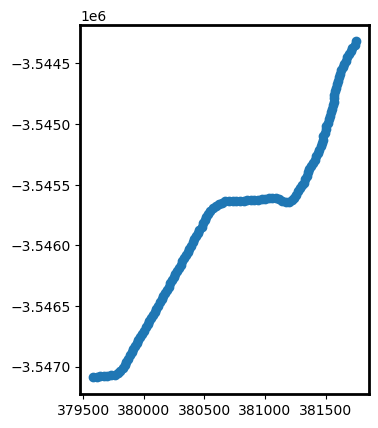

In [19]:
# Extract points at every 30 metres along the most recent shoreline
points_gdf = points_on_line(contours_gdf_mod, index='2022', distance=30)
points_gdf.plot()

In [20]:
# For each 30 m-spaced point, calculate the distance from
# the most recent 2022 shoreline to each other annual shoreline
# in the datasets.
points_gdf = annual_movements(points_gdf,
                              contours_gdf=contours_gdf_mod,
                              yearly_ds=landsat_summaries,
                              baseline_year=2022,
                              water_index='MNDWI')
#points_gdf

In [21]:
# Calculate rates of change using linear regression
points_gdf = calculate_regressions(points_gdf=points_gdf)
points_gdf.to_file('../data/Points_DEA.geojson', driver='GeoJSON')
points_gdf

,rate_time,sig_time,se_time,outl_time,dist_1988,dist_1989,dist_1990,dist_1991,dist_1992,dist_1993,...,dist_2016,dist_2017,dist_2018,dist_2019,dist_2020,dist_2021,dist_2022,angle_mean,angle_std,geometry
0,0.401,0.002,0.118,1995,-18.18,-12.30,-13.24,-18.15,-0.36,-5.71,...,1.86,1.90,-0.12,2.37,1.01,2.58,0.0,104,21,POINT (381748.807 -3544320.000)
1,0.098,0.464,0.132,,-5.69,-3.58,-2.83,-7.04,0.30,1.49,...,2.55,5.63,-0.68,5.19,0.71,5.05,0.0,122,11,POINT (381739.478 -3544348.513)
2,0.003,0.977,0.114,,-4.63,-3.10,-1.85,-9.53,-2.35,2.05,...,0.49,2.49,-2.64,0.90,-3.51,2.36,0.0,123,11,POINT (381720.260 -3544371.394)
3,-0.181,0.138,0.119,,3.00,-0.43,-1.03,-3.10,5.23,8.72,...,-0.24,0.87,-1.77,1.02,-3.55,1.35,0.0,125,10,POINT (381706.441 -3544397.988)
4,-0.283,0.009,0.102,,7.70,1.89,4.94,3.65,9.63,12.38,...,1.34,2.32,-0.92,3.14,-0.31,2.69,0.0,123,10,POINT (381691.824 -3544424.140)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,-0.018,0.437,0.023,,0.79,-3.29,-1.40,-2.33,-3.30,1.47,...,-1.62,-1.09,-1.12,-1.32,-1.03,-0.77,0.0,175,4,POINT (379700.357 -3547075.064)
128,0.010,0.841,0.049,,0.98,-0.78,-1.13,-0.75,-12.63,-0.69,...,-1.76,-1.54,-0.83,-1.66,-1.13,-0.89,0.0,176,5,POINT (379670.443 -3547077.302)
129,-0.076,0.282,0.069,,-0.16,1.00,1.96,0.53,-15.63,-5.55,...,-5.56,-2.83,-2.13,-5.79,-7.27,-2.00,0.0,176,7,POINT (379640.553 -3547079.822)
130,-0.108,0.115,0.067,,-7.23,-4.71,4.48,2.30,-9.48,-2.58,...,-5.22,-7.20,-1.64,-5.54,-7.01,-4.65,0.0,169,9,POINT (379610.921 -3547083.673)


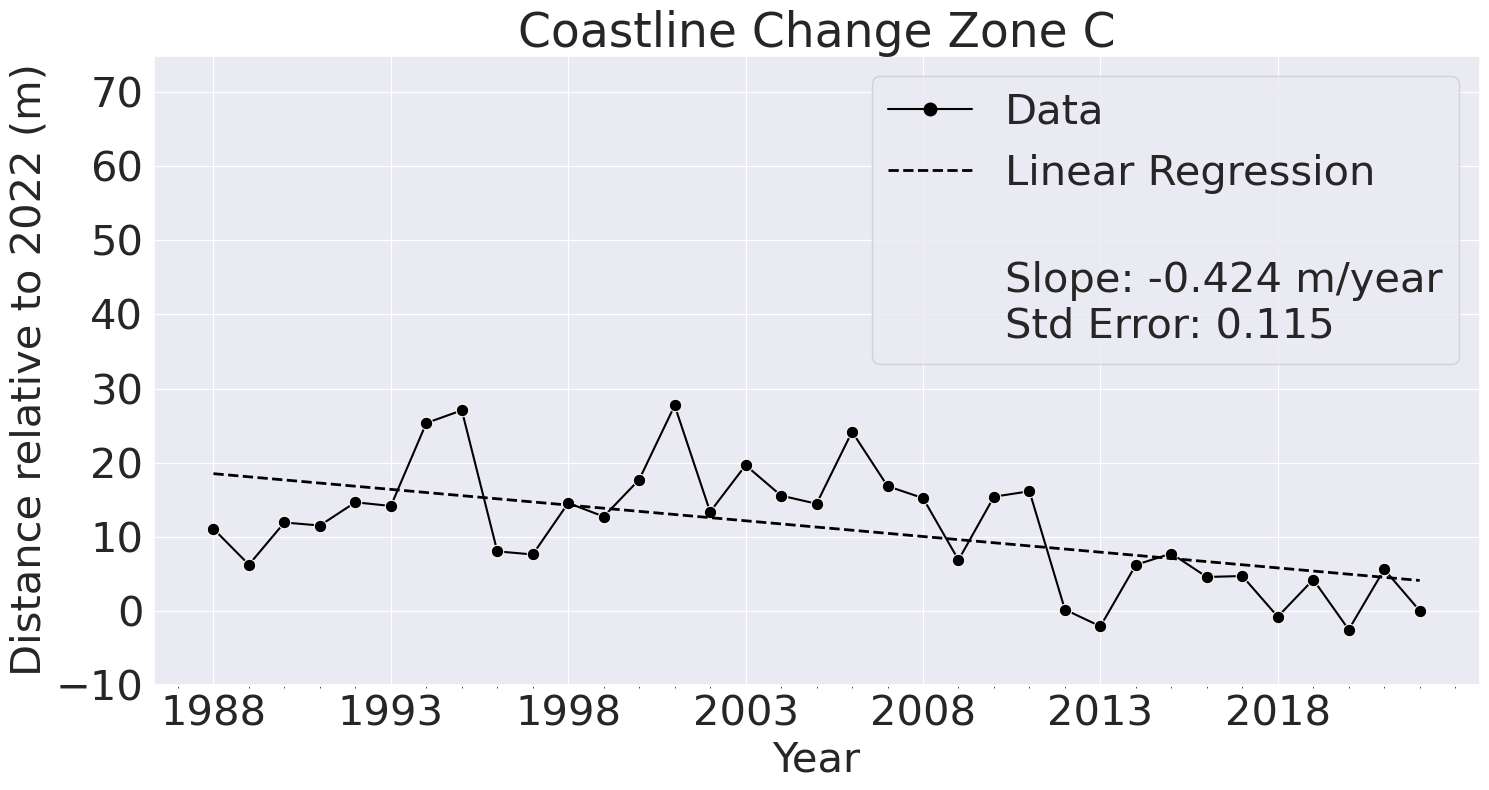

In [24]:
# Transect A→ Index: 46
# Transect B→ Index: 26
# Transect C→ Index: 5

def plot_line_with_regression(df, row_index):
    row = df.loc[row_index]

    # Extract year values from column names
    years = [int(col.split('_')[1]) for col in df.columns if col.startswith('dist_')]

    # Extract distance values
    distances = [row[f'dist_{year}'] for year in years]

    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = linregress(years, distances)
    regression_line = [slope * year + intercept for year in years]

    # Set color palette
    colors = sns.color_palette("Set1", len(years))

    # Set background style
    sns.set_style('darkgrid')

    # Create the plot
    plt.figure(figsize=(15, 8))  # Adjusted size to be smaller and squared
    sns.lineplot(x=years, y=distances, marker='o', markersize=9, color='black', label='Data')
    plt.plot(years, regression_line, color='black', linestyle='dashed', linewidth=2, label='Linear Regression')

    # Set plot title and labels
    plt.title(f"Coastline Change Zone C", fontsize=34)
    plt.xlabel("Year", fontsize=30)
    plt.ylabel("Distance relative to 2022 (m)", fontsize=30)

    # Add regression information to the legend
    legend_text = f"\nSlope: {slope:.3f} m/year\nStd Error: {std_err:.3f}"
    legend_font = {'size': 30}  # Increase the font size of the legend
    plt.legend(loc='upper right', handles=[
        plt.Line2D([], [], marker='o', markersize=9, color='black', label='Data'),
        plt.Line2D([], [], color='black', linestyle='dashed', linewidth=2, label='Linear Regression'),
        plt.Line2D([], [], color='white', label=legend_text, marker='', linestyle='')
    ], prop=legend_font)

    # Set tick locations and labels for years
    plt.xticks(years[::5], fontsize=30)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    plt.tick_params(axis='x', which='minor', bottom=True, labelbottom=False)
    plt.yticks(fontsize=30)
    plt.ylim(-10,75)


    # Save the plot as a PNG file with a dynamic filename based on the title
    filename = f"{plt.gca().get_title()}.png".replace(' ', '_')
    plt.tight_layout()
    plt.savefig('../figures/'+filename, dpi=300)
    plt.show()

plot_line_with_regression(points_gdf, 5)

### 11. Perform possible validation with Vegetation Lines (DOT-023)
Link: https://catalogue.data.wa.gov.au/dataset/coastline-movements

In [25]:
# Load datasets

# DOT
contours_gdf_dot=gpd.read_file('../data/Annual_Veglines_DOT.geojson').set_index('year')
contours_gdf_dot

,OBJECTID,Shape_Length,geometry
year,,,
1990,1,1490.997038,"LINESTRING (381822.940 -3544334.694, 381822.87..."
1993,2,1504.532851,"MULTILINESTRING ((381192.314 -3545655.769, 381..."
1996,3,1649.214889,"MULTILINESTRING ((380941.112 -3545745.854, 380..."
2000,4,1634.901963,"MULTILINESTRING ((380823.153 -3546223.304, 380..."
2004,5,1448.391951,"MULTILINESTRING ((381380.529 -3545358.534, 381..."
2008,6,4291.025463,"MULTILINESTRING ((380810.840 -3546231.932, 380..."
2016,7,1396.682183,"MULTILINESTRING ((381390.614 -3545363.562, 381..."
2019,8,1447.161184,"MULTILINESTRING ((381387.934 -3545361.953, 381..."


<Axes: >

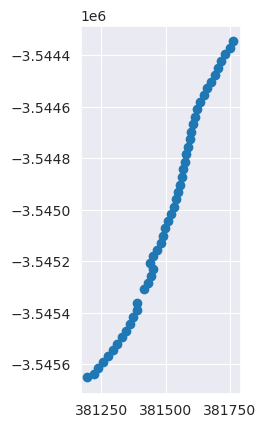

In [26]:
# Extract points at every 30 metres along the 2019 coastline

# DOT
points_gdf_dot = points_on_line(contours_gdf_dot, index=2019, distance=30)
points_gdf_dot.plot()

<Axes: >

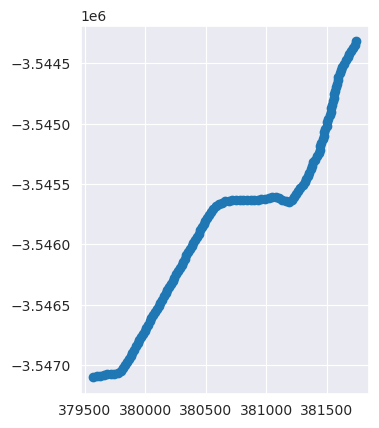

In [27]:
# DEA
points_gdf_mod = points_on_line(contours_gdf_mod, index='2019', distance=30)
points_gdf_mod.plot()

In [28]:
# For each 30 m-spaced point, calculate the distance from
# the most recent 2019 shoreline to each other annual shoreline
# in the datasets.

# DOT
points_gdf_dot = annual_movements(points_gdf_dot,
                                  contours_gdf=contours_gdf_dot,
                                  yearly_ds=landsat_summaries,
                                  baseline_year=2019,
                                  water_index='MNDWI')

In [29]:
# DEA
points_gdf_mod = annual_movements(points_gdf_mod,
                                  contours_gdf=contours_gdf_mod,
                                  yearly_ds=landsat_summaries,
                                  baseline_year=2019,
                                  water_index='MNDWI')

In [30]:
# Calculate rates of change using linear regression

# DOT
points_gdf_dot = calculate_regressions(points_gdf=points_gdf_dot)
points_gdf_dot.to_file('../data/Points_DOT.geojson', driver='GeoJSON')

In [31]:
# DEA
points_gdf_mod = calculate_regressions(points_gdf=points_gdf_mod)
points_gdf_mod.to_file('../data/Points_DEA_modified_2019.geojson', driver='GeoJSON')
points_gdf_mod

,rate_time,sig_time,se_time,outl_time,dist_1988,dist_1989,dist_1990,dist_1991,dist_1992,dist_1993,...,dist_2016,dist_2017,dist_2018,dist_2019,dist_2020,dist_2021,dist_2022,angle_mean,angle_std,geometry
0,0.385,0.002,0.115,1995,-19.94,-14.06,-15.02,-19.95,-2.60,-7.55,...,-0.48,-0.42,-2.38,0.0,-1.29,0.21,-2.25,109,20,POINT (381746.441 -3544320.000)
1,0.084,0.533,0.134,,-10.28,-8.21,-7.42,-11.91,-4.96,-3.54,...,-2.71,0.47,-5.90,0.0,-4.57,0.15,-5.24,124,11,POINT (381734.283 -3544347.426)
2,-0.008,0.943,0.114,,-4.81,-3.33,-2.04,-9.98,-2.77,1.59,...,-0.25,1.58,-3.02,0.0,-4.05,1.58,-0.56,122,10,POINT (381718.632 -3544372.927)
3,-0.203,0.095,0.118,,2.47,-1.42,-0.08,-3.75,4.62,8.26,...,-1.43,-0.32,-2.88,0.0,-4.74,0.15,-1.17,125,10,POINT (381704.485 -3544399.337)
4,-0.283,0.009,0.102,,4.76,-0.99,2.38,1.19,6.87,9.36,...,-1.44,-0.79,-3.68,0.0,-2.06,-0.28,-2.81,122,10,POINT (381688.351 -3544424.401)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.005,0.890,0.037,,2.30,-0.79,-0.74,0.19,-7.16,2.13,...,-0.21,-0.40,0.58,0.0,0.86,0.40,1.35,175,6,POINT (379683.733 -3547077.504)
128,-0.022,0.742,0.066,,5.04,5.18,4.85,3.57,-11.66,-1.65,...,-0.07,3.16,3.00,0.0,-0.66,3.35,4.07,172,10,POINT (379654.396 -3547082.920)
129,-0.114,0.105,0.069,,-1.13,4.49,9.86,8.92,-6.59,5.53,...,0.80,0.18,4.17,0.0,-1.75,2.16,4.86,173,11,POINT (379624.859 -3547087.556)
130,-0.039,0.577,0.068,,1.46,-4.31,2.82,0.73,-0.96,-5.06,...,-0.97,-3.81,3.13,0.0,-0.76,-0.74,7.36,167,12,POINT (379595.080 -3547091.190)


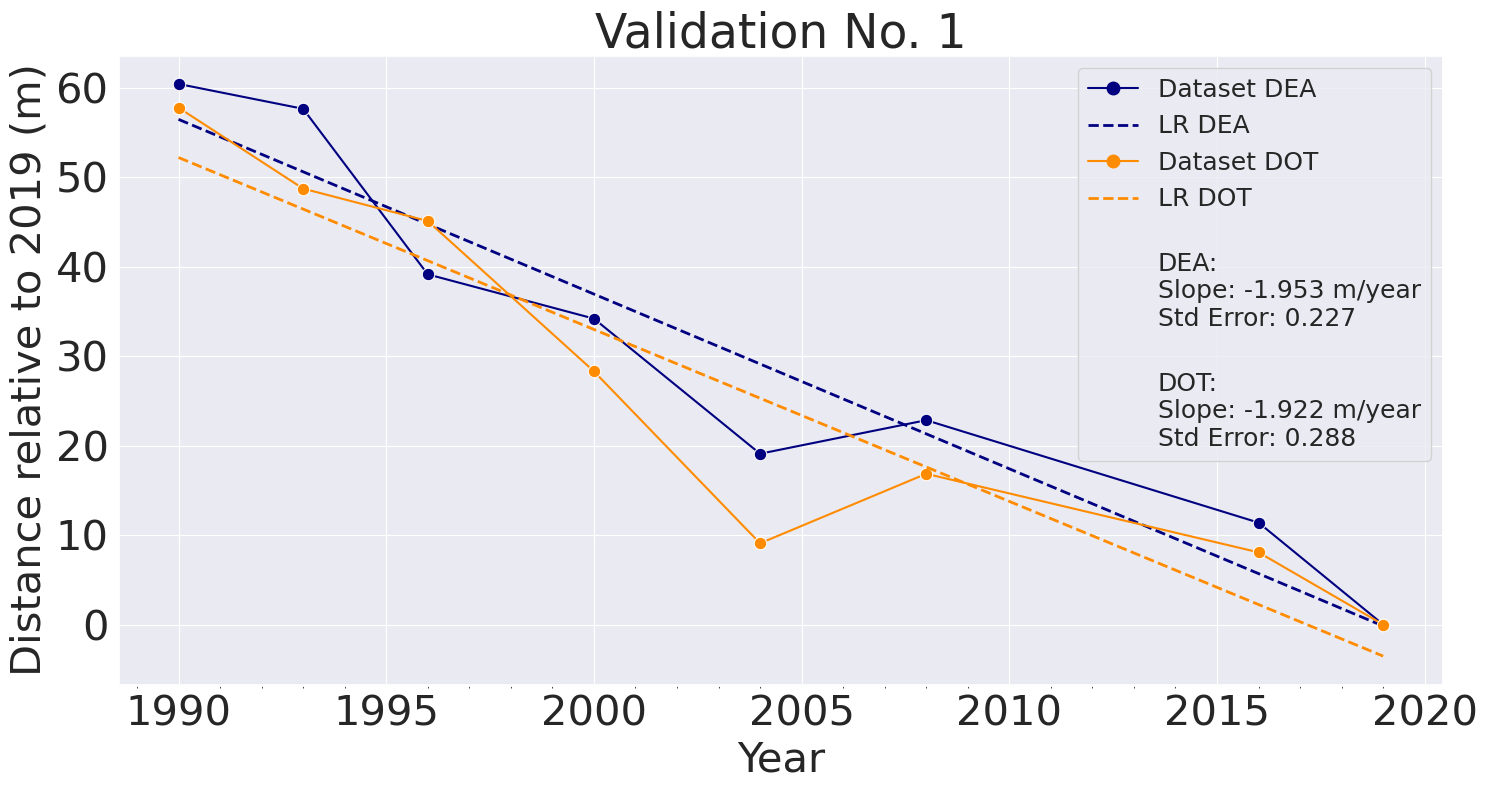

In [38]:
# df1: DEA & df2: DOT
# Reference 1→ Indexes: 43,6
# Reference 2→ Indexes: 19,31

def plot_validations(df1, row_index1, df2, row_index2):
    row1 = df1.loc[row_index1]
    row2 = df2.loc[row_index2]

    # Extract year values from column names
    years = [int(col.split('_')[1]) for col in df2.columns if col.startswith('dist_')]

    # Extract distance values for df1
    distances1 = [row1[f'dist_{year}'] for year in years]

    # Extract distance values for df2
    distances2 = [row2[f'dist_{year}'] for year in years]

    # Calculate linear regression for df1
    slope1, intercept1, r_value1, p_value1, std_err1 = linregress(years, distances1)
    regression_line1 = [slope1 * year + intercept1 for year in years]

    # Calculate linear regression for df2
    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(years, distances2)
    regression_line2 = [slope2 * year + intercept2 for year in years]

    # Set color palettes
    colors1 = sns.color_palette("Set1", len(years))
    colors2 = sns.color_palette("Set2", len(years))

    # Set background style
    sns.set_style('darkgrid')

    # Create the plot
    plt.figure(figsize=(15, 8))  # Adjusted size to be smaller and squared

    # Plot data and linear regression for df1
    sns.lineplot(x=years, y=distances1, marker='o', markersize=9, color='navy', label='Data1')
    plt.plot(years, regression_line1, color='navy', linestyle='dashed', linewidth=2, label='Linear Regression1')

    # Plot data and linear regression for df2
    sns.lineplot(x=years, y=distances2, marker='o', markersize=9, color='darkorange', label='Data2')
    plt.plot(years, regression_line2, color='darkorange', linestyle='dashed', linewidth=2, label='Linear Regression2')

    # Set plot title and labels
    plt.title(f"Validation No. 1", fontsize=34)
    plt.xlabel("Year", fontsize=30)
    plt.ylabel("Distance relative to 2019 (m)", fontsize=30)

    # Add regression information to the legend
    legend_text1 = f"\nDEA:\nSlope: {slope1:.3f} m/year\nStd Error: {std_err1:.3f}"
    legend_text2 = f"\nDOT:\nSlope: {slope2:.3f} m/year\nStd Error: {std_err2:.3f}"
    legend_font = {'size': 18}  # Increase the font size of the legend
    plt.legend(loc='best', handles=[
        plt.Line2D([], [], marker='o', markersize=9, color='navy', label='Dataset DEA'),
        plt.Line2D([], [], color='navy', linestyle='dashed', linewidth=2, label='LR DEA'),
        plt.Line2D([], [], marker='o', markersize=9, color='darkorange', label='Dataset DOT'),
        plt.Line2D([], [], color='darkorange', linestyle='dashed', linewidth=2, label='LR DOT'),
        plt.Line2D([], [], color='white', label=legend_text1, marker='', linestyle=''),
        plt.Line2D([], [], color='white', label=legend_text2, marker='', linestyle='')
    ], prop=legend_font)

    # Set tick locations and labels for years
    plt.xticks(fontsize=30)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    plt.tick_params(axis='x', which='minor', bottom=True, labelbottom=False)
    plt.yticks(fontsize=30)
    #plt.ylim(-10, 40)

    # Save the plot as a PNG file with a dynamic filename based on the title
    filename = f"{plt.gca().get_title()}.png".replace(' ', '_')
    plt.tight_layout()
    plt.savefig('../figures/'+filename, dpi=300)
    plt.show()

plot_validations(points_gdf_mod,43 , points_gdf_dot,6)


### References

* Krause, C., Dunn, B., Bishop-Taylor, R., Adams, C., Burton, C., Alger, M., Chua, S., Phillips, C., Newey, V., Kouzoubov, K., Leith, A., Ayers, D., Hicks, A., Contributors, D. E. A., & Chua, S. (2021). Digital Earth Australia notebooks and tools repository. Geoscience Australia, Canberra. https://doi.org/10.26186/145234
* Bishop-Taylor, R., Nanson, R., Sagar, S., & Lymburner, L. (2021). Mapping Australia’s dynamic coastline at mean sea level using three decades of Landsat imagery. Remote Sensing of Environment, 267, 112734. https://doi.org/10.1016/j.rse.2021.112734